ИТОГ

Почему то на разных игрушечных датасетах из sklearn классификатор всегда находит (локальный?) оптимум и не выходит из него считая его лучшим разделителем выборки. Потерял интерес после того, как не понял правильное ли это поведение или нет.

# Open toy dataset

In [329]:
from sklearn.datasets import load_breast_cancer
# from sklearn.datasets import load_wine
data = load_breast_cancer()
# top = 130
top = 99999
X = data.data[:top, :2]
y = data.target[:top]


# Decision Tree Classifier

In [330]:
class DecisionStump():
    """
    Weak classifier.
    Is equal to sklearn.tree.DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
    """
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.threshold_w = None
        self.alpha = None
        self.missclassified = None
        
    def fit(self, X, y, sample_weight=None):
        """
        find best split (threshold) in descicion tree node
        """
        if sample_weight is None:
            sample_weight = [1] * X.shape[0]
        y[y == 0] = -1
        thresholds = np.unique(X)
        missclassified_ = []
        for n, x_j in enumerate(thresholds):
            self.threshold = x_j
            self.threshold_w = x_j*sample_weight[n]
            weak_learner_preds = self.predict(X, sample_weight)
            missclassified_.append(self.missclassification(y, weak_learner_preds))
        self.threshold = thresholds[np.argmin(missclassified_)]
        self.threshold_w = self.threshold*sample_weight[np.argmin(missclassified_)]
        self.missclassified = self.missclassification(y, self.predict(X, sample_weight))
        
    def missclassification(self, y, y_hat):
        return sum(y != y_hat)
    
    def predict(self, X, weights, use_weighted_thresh=True):
        preds = np.ones(X.shape[0])
        if use_weighted_thresh:
            preds[X*weights < self.threshold_w] = 3
        else:
            preds[X*weights < self.threshold] = 3
        preds -= 2
        return preds

# AdaBoost

In [341]:
import numpy as np


class AdaBoost():
    def __init__(self, estimators=5):
        self.weights = np.expand_dims(np.ones(1), axis=0) # empty weights, redundant
        self.estimators = estimators
        self.weak_learners = []
    
    def accuracy(self, loss):
        """
        """
        return np.log((1 - loss) / loss) / 2 # do we really need to divide by 2?
        
    def fit(self, X, y):
        self.weights = np.ones(X.shape) / X.shape[0]
        for i in range(self.estimators):
            temp_clfs = []
            for feature in range(X.shape[1]):
                clf = DecisionStump()
                clf.fit(X[:,feature], y, sample_weight=self.weights[:,feature])
                temp_clfs.append(clf)

            best_weak_learner_index = np.argmin([temp_clf.missclassified for temp_clf in temp_clfs])  # choose best weak learner
            self.weak_learners.append(temp_clfs[best_weak_learner_index])               # save it
            acc = self.accuracy(self.weak_learners[-1].missclassified / X.shape[0])     # count its accuracy
            print('accuracy', acc)
            self.weak_learners[-1].alpha = acc                                          # save it inside weak learner
            self.weak_learners[-1].feature_index = best_weak_learner_index              # save feature index by which we split
            y_hat = self.weak_learners[-1].predict(X[:,best_weak_learner_index], self.weights[:,best_weak_learner_index])
            
            print('Точка сплита слабого классификатора:', self.weak_learners[-1].threshold)
            
            # update weights
            self.weights[:,best_weak_learner_index] = (self.weights[:,best_weak_learner_index] * \
                                                       np.exp(-acc * y * y_hat)) / self.weights[:,best_weak_learner_index].sum()

    def predict(self, X):
        # TODO не доделан
        preds = []
        for x_i in range(X.shape[0]):
            x_i_pred = []
            for weak_learner in self.weak_learners:
                preds.append(weak_learner.predict(X[x_i:x_i+1,weak_learner.feature_index], self.weights))  #  * weak_learner.alpha
            
        return np.sign()
                
    
clf = AdaBoost()
clf.fit(X, y)
# clf.predict(X[:3,:])


accuracy 1.050688309273046
Точка сплита слабого классификатора: 15.05
accuracy 1.9632318447914703
Точка сплита слабого классификатора: 15.05
accuracy 1.9632318447914703
Точка сплита слабого классификатора: 15.05
accuracy 1.9632318447914703
Точка сплита слабого классификатора: 15.05
accuracy 1.9632318447914703
Точка сплита слабого классификатора: 15.05


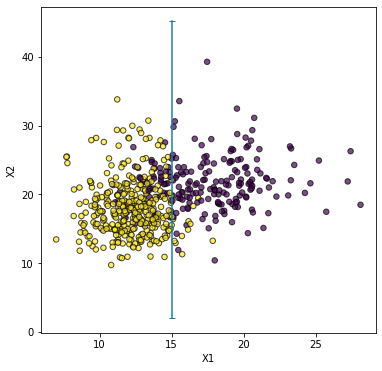

In [338]:
import matplotlib.pyplot as plt
import numpy as np

# x1 = (np.ones(X.shape) / X.shape[0] * X)[:,0]
# x2 = (np.ones(X.shape) / X.shape[0] * X)[:,1]
x1 = X[:,0]
x2 = X[:,1]
z = y

fig = plt.figure(figsize=(6, 6))
plt.scatter(x1, x2,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 30,
           c=z)

line1 = 15.05 # / X.shape[0]
# line2 = 19.62 # / X.shape[0]
plt.plot([line1, line1], [2, line1*3], marker = '_') # /X.shape[0]
# plt.plot([line2, 7], [line2, line2], marker = '_') # /X.shape[0] 
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# classify stumps by hand

### first weak classifier

In [312]:
clf1 = DecisionStump()
clf2 = DecisionStump()
weights = np.ones(X.shape) / X.shape[0]
weights[0,:], y.shape

(array([0.00175747, 0.00175747]), (569,))

In [313]:
clf1.fit(X[:,0], y, sample_weight=weights[:,0])
clf2.fit(X[:,1], y, sample_weight=weights[:,1])

In [314]:
clf1.missclassified, clf1.threshold, clf1.threshold_w

(62, 15.05, 0.026449912126537786)

In [315]:
clf2.missclassified, clf2.threshold, clf2.threshold_w

(150, 19.62, 0.03448154657293497)

In [316]:
best_weak_learner_index = np.argmin([temp_clf.missclassified for temp_clf in [clf1, clf2]])  # choose best weak learner
best_weak_learner_index

0

In [317]:
weak_learners = []

In [318]:
weak_learners.append([clf1, clf2][best_weak_learner_index])               # save it

In [319]:
def accuracy(loss):
    """
    explain
    """
    return np.log((1 - loss) / loss) / 2

In [320]:
accuracy(weak_learners[-1].missclassified / X.shape[0])

1.050688309273046

In [321]:
weak_learners[-1].alpha = accuracy(weak_learners[-1].missclassified / X.shape[0])

In [322]:
weak_learners[-1].feature_index = best_weak_learner_index              # save feature index by which we split

In [323]:
y_hat = weak_learners[-1].predict(X[:,best_weak_learner_index], weights[:,best_weak_learner_index])

In [324]:
acc = accuracy(sum(y != y_hat)/ X.shape[0])
acc

1.050688309273046

In [325]:
weights[:,best_weak_learner_index] = (weights[:,best_weak_learner_index] * np.exp(-acc * y * y_hat)) / weights[:,best_weak_learner_index].sum()
weights[0,:]

array([0.00061458, 0.00175747])

### second weak classifier

In [257]:
clf3 = DecisionStump()
clf4 = DecisionStump()

In [258]:
clf3.fit(X[:,0], y, sample_weight=weights[:,0])
clf4.fit(X[:,1], y, sample_weight=weights[:,1])

In [263]:
clf3.missclassified, clf3.threshold, clf3.threshold_w

(11, 15.05, 0.009249454037205946)

In [264]:
clf4.missclassified, clf4.threshold, clf4.threshold_w

(150, 19.62, 0.03448154657293497)

In [268]:
best_weak_learner_index = np.argmin([temp_clf.missclassified for temp_clf in [clf3, clf4]])  # choose best weak learner
best_weak_learner_index

0

In [269]:
weak_learners.append([clf3, clf4][best_weak_learner_index])               # save it

In [273]:
weak_learners[-1].missclassified / X.shape[0]

0.019332161687170474

In [271]:
accuracy(weak_learners[-1].missclassified / X.shape[0])

1.9632318447914703

In [276]:
weak_learners[-1].alpha = accuracy(weak_learners[-1].missclassified / X.shape[0])

In [277]:
weak_learners[-1].feature_index = best_weak_learner_index              # save feature index by which we split

In [278]:
y_hat = weak_learners[-1].predict(X[:,best_weak_learner_index], weights[:,best_weak_learner_index])

In [279]:
acc = accuracy(sum(y != y_hat)/ X.shape[0])
acc

1.9632318447914703

In [280]:
weights[:,best_weak_learner_index] = (weights[:,best_weak_learner_index] * np.exp(-acc * y * y_hat)) / weights[:,best_weak_learner_index].sum()
weights[0,:]

array([0.00013847, 0.00175747])

### third weak classifier

In [281]:
clf5 = DecisionStump()
clf6 = DecisionStump()
clf5.fit(X[:,0], y, sample_weight=weights[:,0])
clf6.fit(X[:,1], y, sample_weight=weights[:,1])

In [282]:
clf5.missclassified, clf5.threshold, clf5.threshold_w

(11, 15.05, 0.002083904382737046)

In [283]:
clf6.missclassified, clf6.threshold, clf6.threshold_w

(150, 19.62, 0.03448154657293497)

### pred

In [326]:
preds = np.ones(1)
preds[X[0,weak_learners[0].feature_index] < weak_learners[0].threshold] = 3
preds -= 2
np.sign(preds * weak_learners[0].alpha)

array([-1.])

In [327]:
y[0]

-1